In [1]:
!pip install nltk
!pip install -q wordcloud
!pip install matplotlib
!pip install vaderSentiment

In [2]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from nltk.corpus import stopwords

stop = stopwords.words('english')

df = pd.read_csv("./datasets/train2Data.csv", encoding="utf-8", sep=',')

df.rename(columns={'Tweets': 'text', ' Label': 'label'}, inplace=True)

#Remove stopwords from the dataset
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df['text'] = df['text'].apply(lambda x: ' '.join([item for item in x.split() if item not in ['amp', 'quot']]))

In [ ]:

from nrclex import NRCLex
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

df['fear'] = df['text'].apply(lambda x: NRCLex(x).raw_emotion_scores.get('fear', 0))

df['anger'] = df['text'].apply(lambda x: NRCLex(x).raw_emotion_scores.get('anger', 0))

df['anticipation'] = df['text'].apply(lambda x: NRCLex(x).raw_emotion_scores.get('anticipation', 0))

df['trust'] = df['text'].apply(lambda x: NRCLex(x).raw_emotion_scores.get('trust', 0))

df['surprise'] = df['text'].apply(lambda x: NRCLex(x).raw_emotion_scores.get('surprise', 0))

df['positive'] = df['text'].apply(lambda x: NRCLex(x).raw_emotion_scores.get('positive', 0))

df['negative'] = df['text'].apply(lambda x: NRCLex(x).raw_emotion_scores.get('negative', 0))

df['sadness'] = df['text'].apply(lambda x: NRCLex(x).raw_emotion_scores.get('sadness', 0))

df['disgust'] = df['text'].apply(lambda x: NRCLex(x).raw_emotion_scores.get('disgust', 0))

df['joy'] = df['text'].apply(lambda x: NRCLex(x).raw_emotion_scores.get('joy', 0))

for index, row in df.iterrows():
    sentence = row['text']
    sentiment = analyzer.polarity_scores(sentence)

    df.at[index, 'negative'] = sentiment['neg']
    df.at[index, 'neutral'] = sentiment['neu']
    df.at[index, 'positive'] = sentiment['pos']
    df.at[index, 'compound'] = sentiment['compound']



In [6]:
df['Message Size'] = df['text'].apply(lambda x: len(x))

In [7]:
df.head(10)

,text,label,fear,anger,anticipation,trust,surprise,positive,negative,sadness,disgust,joy,Message Size
0,damn taking personality quiz realizing severe ...,1,0,1,0,0,0,0,3,1,1,0,56
1,remember experiencing kid realize clinical dep...,1,1,2,2,1,1,2,4,2,2,1,141
2,damn louis really pull depression painting fir...,1,0,1,1,0,0,1,2,1,1,0,60
3,depression really kicking ass right damn tired,1,0,2,0,0,0,0,4,1,1,0,46
4,feel like night going bad family calling grump...,1,1,3,0,0,0,0,4,3,3,0,80
5,im really trying embrace depression needs take...,1,0,1,2,1,1,2,2,1,1,2,75
6,please mom put strict carb diet know im fatass...,1,1,2,0,0,0,1,3,2,2,0,83
7,medication helped much like literally worst me...,1,1,2,1,0,0,0,4,2,2,0,160
8,healthy amount depression helps weight loss pa...,1,2,1,1,1,2,2,3,3,1,1,108
9,oh man thats really rough hard manage stress d...,1,1,2,1,3,0,2,5,3,1,1,117


In [8]:
!pip install seaborn

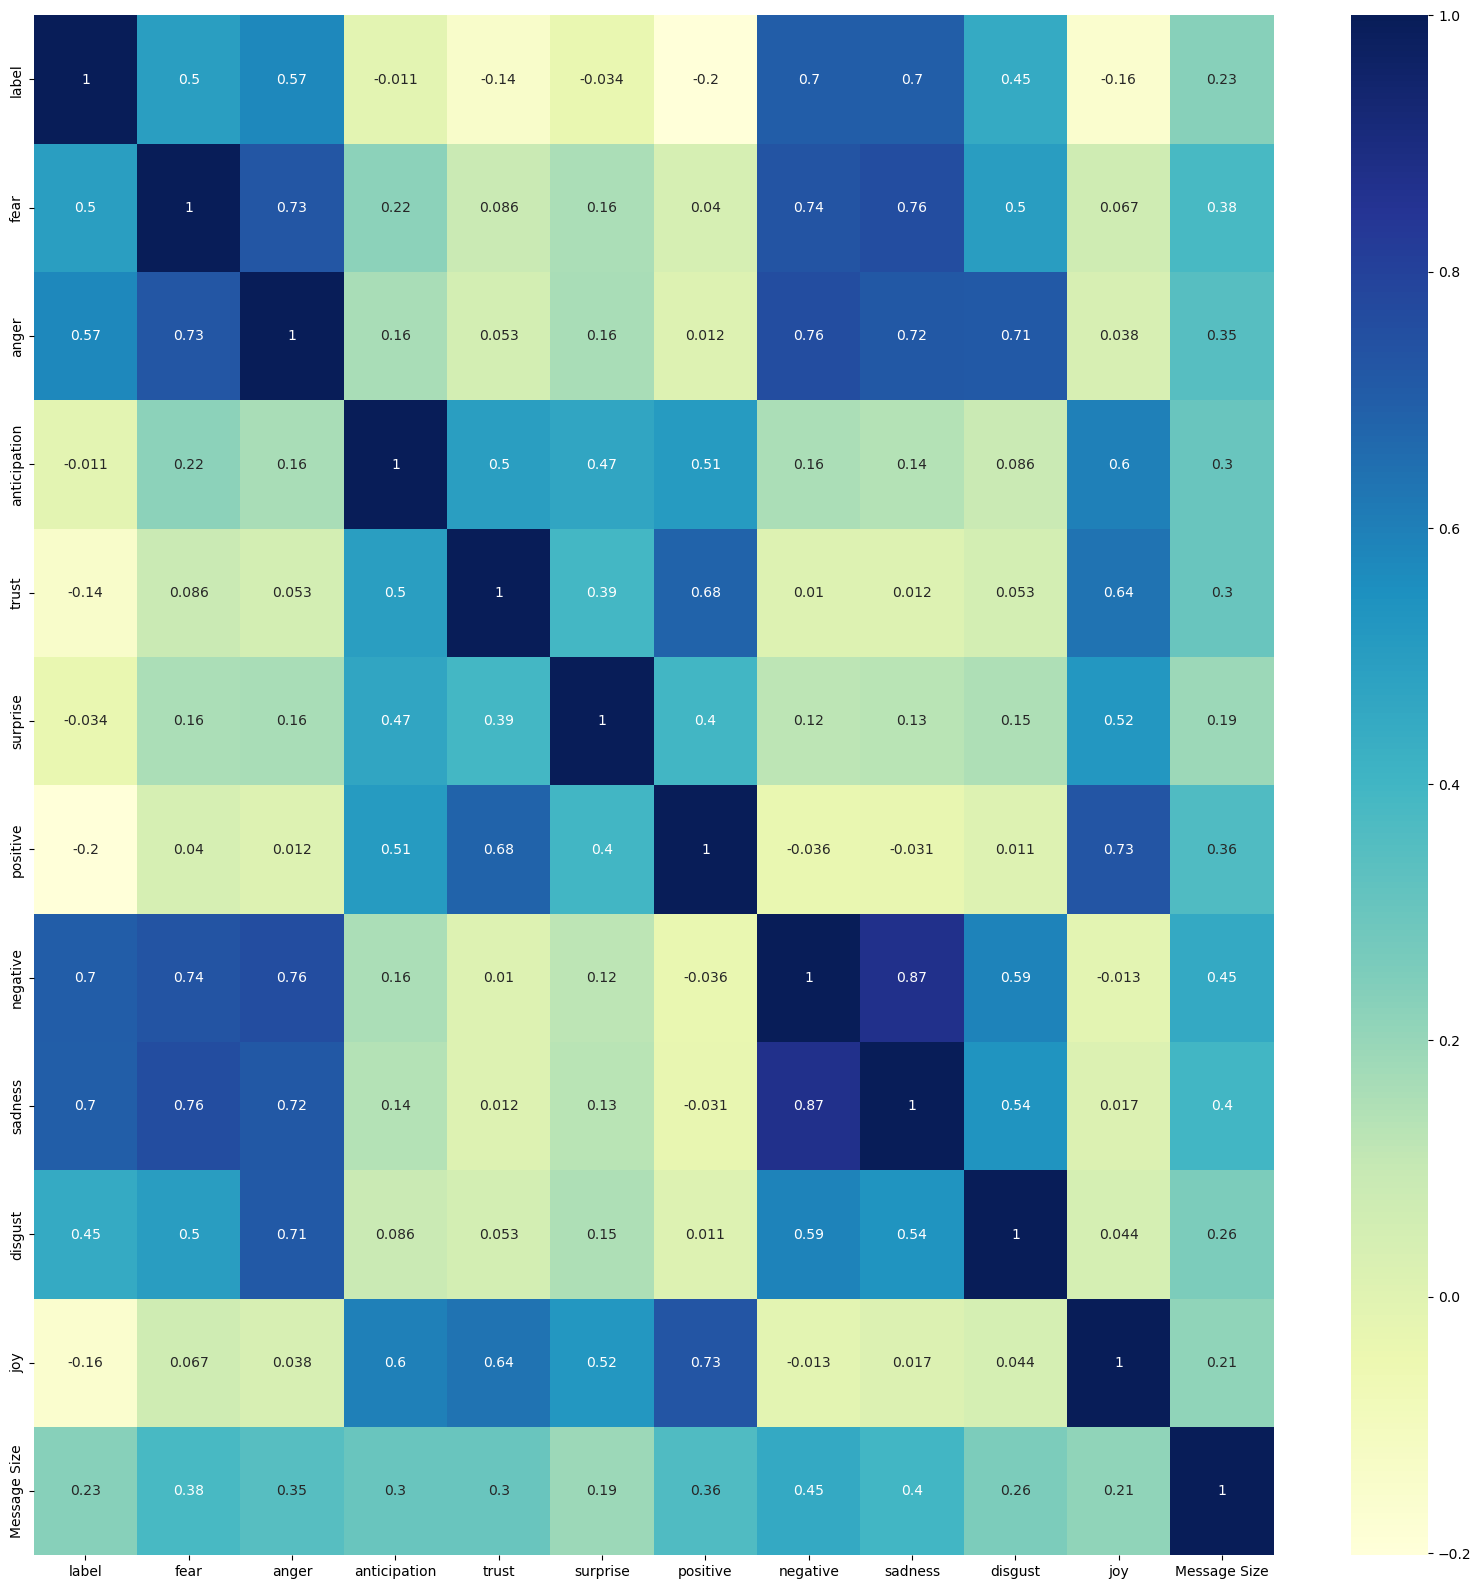

In [16]:
# import modules 
import matplotlib.pyplot as mp
import pandas as pd
import seaborn as sb

df1 = df.copy();

df1.drop(columns=['text'], inplace=True)

plt.figure(figsize=(15, 15))
# plotting correlation heatmap 
dataplot = sb.heatmap(df1.corr(), cmap="YlGnBu", annot=True)

# displaying heatmap 
mp.show()

In [19]:
!pip install tensorflow
!pip install keras
!pip install scikit-learn

In [131]:
from sklearn.model_selection import train_test_split

X = df['text']
y = df['label']

y.head(1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [132]:
X_train

20509          scriptures say paragraph love yah feel like
19503    ear device calm sound sensitivities reduce str...
20098    yah go anywhere near us right someone lives ho...
16307       must sure motive sure result ft island jonghun
27485    ending actually super excited terms story next...
                               ...                        
20680    seahawks waste last time one review play alrea...
11876    suffer severe anxiety depression causes avoid ...
23504    go wondering obsessed trying muddle waters usi...
5125     feeling depressed low stress want go home scre...
29097    bs way thru sharing cuz group didnt know heck ...
Name: text, Length: 24800, dtype: object

In [133]:
from keras.preprocessing.text import Tokenizer

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [135]:
from keras.preprocessing.sequence import pad_sequences

vocab_length = len(word_tokenizer.word_index) + 1

X_train = pad_sequences(X_train, 100);
X_test = pad_sequences(X_test, 100);

In [136]:
from numpy import asarray
from numpy import zeros

embedding_dictionary = {}

glove_file = open('./datasets/glove.6B.300d.txt', encoding="utf-8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embedding_dictionary[word] = vector_dimensions
glove_file.close()

In [137]:
embedding_matrix = zeros((vocab_length, 300))
for word, i in word_tokenizer.word_index.items():
    embedding_vector = embedding_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
embedding_matrix.shape
    

(31937, 300)

In [145]:
from keras import Model
from keras.src import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,Flatten,Dense, Bidirectional, LSTM, Input, Dropout, concatenate

nlp_input = Input(shape=(max_length,), name='nlp_input')
meta_input = Input(shape=(10,), name='meta_input')
emb = Embedding(output_dim=300, input_dim=300, input_length=max_length)(nlp_input)
nlp_out = Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=regularizers.l2(0.01)))(emb)
x = concatenate([nlp_out, meta_input])
x = Dense(128, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=[nlp_input , meta_input], outputs=[x])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 nlp_input (InputLayer)      [(None, 100)]                0         []                            
                                                                                                  
 embedding_14 (Embedding)    (None, 100, 300)             90000     ['nlp_input[0][0]']           
                                                                                                  
 bidirectional_1 (Bidirecti  (None, 256)                  439296    ['embedding_14[0][0]']        
 onal)                                                                                            
                                                                                                  
 meta_input (InputLayer)     [(None, 10)]                 0         []                        

In [146]:
model_history = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1)

Epoch 1/10


ValueError: in user code:

    File "C:\Users\jneig\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\jneig\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\jneig\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\jneig\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\jneig\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\jneig\anaconda3\Lib\site-packages\keras\src\engine\input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 100) dtype=int32>]


In [142]:
model.evaluate(X_test, y_test, verbose=1)

194/194 [==============================] - 0s 1ms/step - loss: 1.5975 - acc: 0.8358


[1.5974845886230469, 0.8358064293861389]